# Neural Ordinary Differential Equations (NeurIPS18)

[Paper](https://arxiv.org/abs/1806.07366)
[Code](https://github.com/rtqichen/torchdiffeq/)
[Slides](http://www.cs.toronto.edu/~duvenaud/talks/ode-talk.pdf)
[Hacker News](https://news.ycombinator.com/item?id=18676986)

## Why did you pick this work?
- An interesting idea (personally), connect and leverage an important math/science concept/tool to deep learning
- Drop-in replacement for Resnet (with some caveat)
- Promising application in generative modeling (normalizing flow)
- A break from RL :)

## TL;DR
The paper main contributions:
- Introduces a continuous-depth DNN architecture, Neural ODE (NODE), inspired by Resnet and can replace Resnet
- How to efficiently train NODE with continuous backpropagation using ordinary differential equations (ODE)
- Interesting applications in time-series and generative models.

# First-order Ordinary Differential Equations

Describe a vector-valued $z(t) \in \mathbb{R}^d$ changes in time,
$$
\frac{dz(t)}{dt} = f(z(t), t)
$$

Initial value problem (IVP): Given $z(t_0)$, find 
$$z(t_1) = z(t_0) + \int_{t_0}^{t_1} f(z(t), t)~dt$$

In practice, it's often prohibitively difficult to find the closed-form solution. Instead, use numerical methods, aka __ODE solvers__ to find approximations:
- many sophisticated methods (e.g., [Runge-Kutta](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods)) with adaptive error control have been developed over $\ge 120$ years $\rightarrow$ widely used in engineering and science and __now deep ML__

$$z(t_1) = \text{ODE}(z(t_0), f, t_0, t_1, \text{error_tolerance_param})$$

# Simple Euler method

For simplicity and illustrative purpose, let's see how the [Euler method](https://en.wikipedia.org/wiki/Euler_method) finds an approximate for the IVP:
- divide the range $[t_0, t_1]$ into small steps of length $h$
- compute the trajectory with $z(t_0+(i+1)h) = z(t_0+ih) + hf(z(t_0+ih), t_0+ih)$

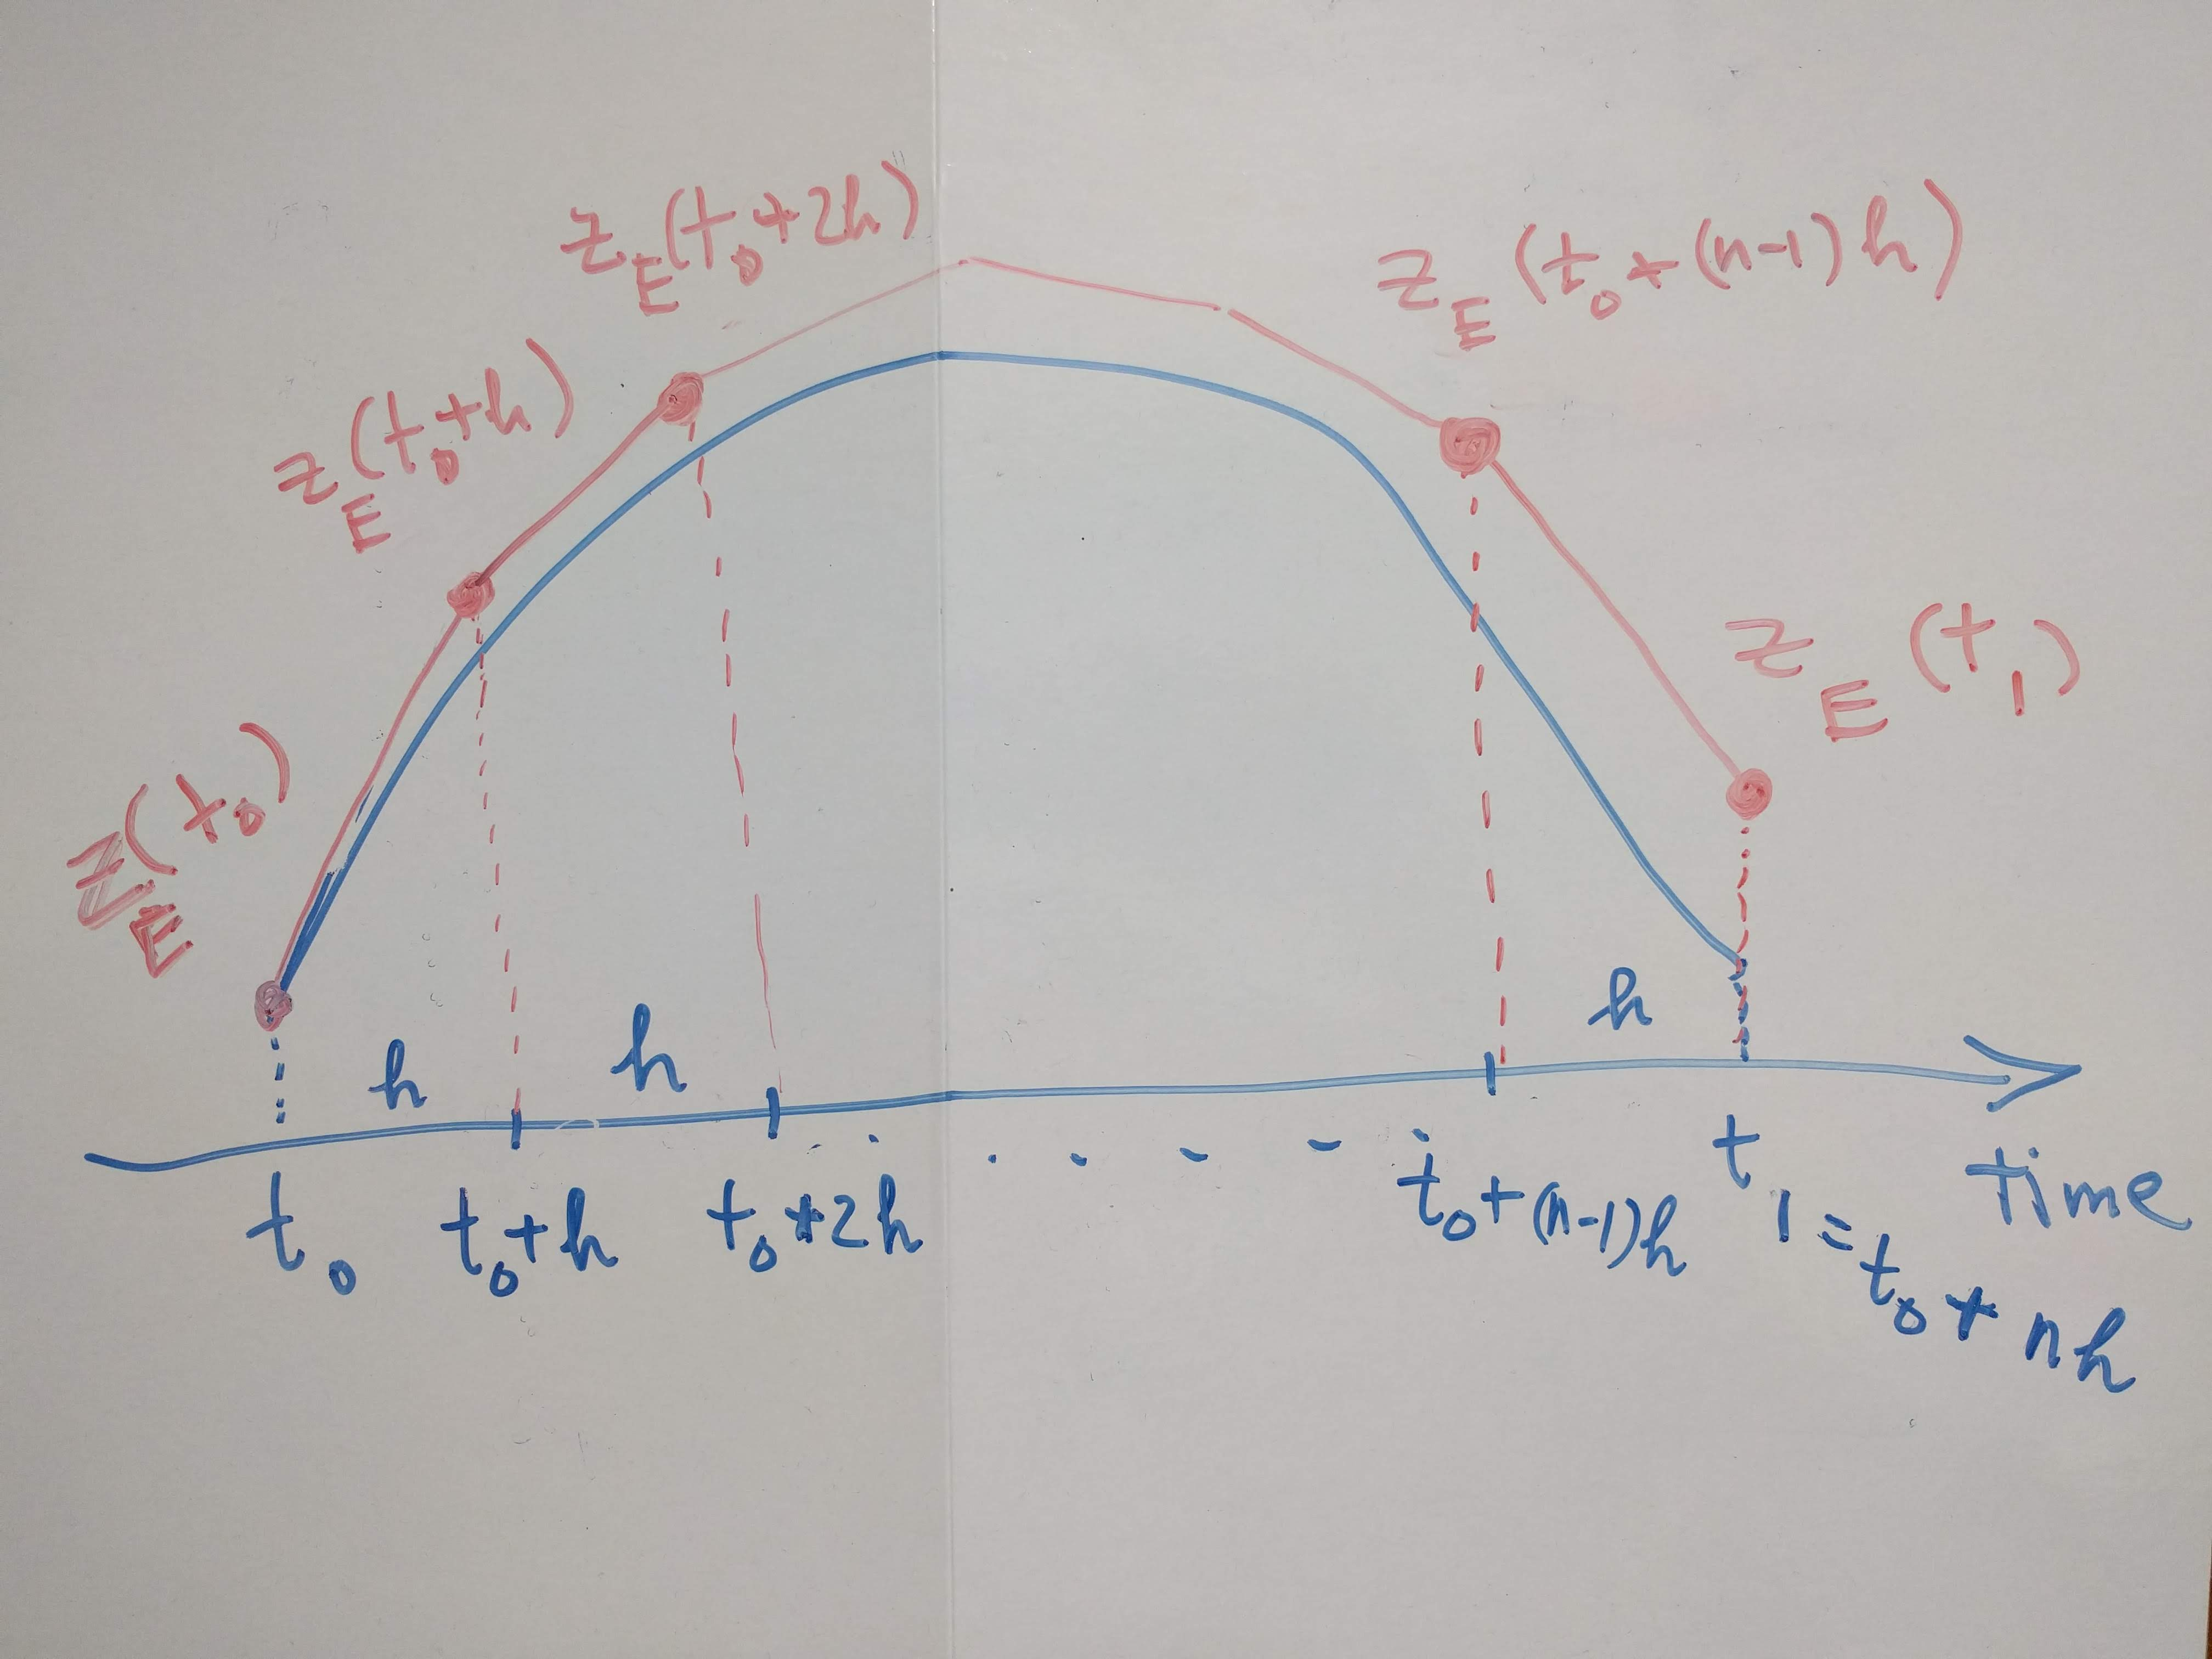

In [11]:
from IPython.display import Image, display
display(Image('figures/euler-ode.jpg', width=600, height=300))

![euler-ode](figures/euler-ode.jpg)

## How about Resnet?

$$
\begin{matrix}
z_0 &=& x \\
z_1 &=& z_0 + f(z_0, \theta_0) \\
z_2 &=& z_1 + f(z_1, \theta_1) \\
&\cdots& \\
z_L &=& z_{L-1} + f(z_{L-1}, \theta_{L-1})
\end{matrix}
$$

i.e., $$\frac{z_{t+dt} - z_t}{dt} = f(z_t, \theta_t),$$ where $dt=1$.

What if we increase the number of layers and take smaller step $dt \rightarrow 0$, at the extreme
$$\frac{dz(t)}{dt} = f(z(t), \theta(t))$$

# Neural ODE

## Forward IVP:
$z(t_0) = x$

Model the dynamics $dz(t)~/~dt$ as $f(z(t), t, \theta)$ parameterized by $\theta \in \mathbb{R}^m$. Note that $\theta$ doesn't depend on time $t$; but instead the dynamics model takes time as input.

## How to learn the dynamics model
The ODE solution at some time $t_1$, i.e., $z(t_1)$ is input to some loss function (problem-specific):
$$L(z(t_1)) = L(\text{ODE}(z(t_0), f, t_0, t_1, \theta))$$

We need to backprop through the ODE solver to find $\partial{L} / \partial{\theta}$. Here comes the main contribution of the paper, __continuous backpropagation by solving a backward IVP__.

## Continuous backprop

Adjoint state: $a(t) := \frac{dL}{dz(t)}$,

$$\frac{da(t)}{dt} = -a(t)\frac{\partial f(z(t), t, \theta)}{\partial z(t)}$$

See the paper appendix for a proof.

We can also view $\theta$ and time $t$ as states with constant differential equations,

- $\frac{d\theta(t)}{dt} = 0 \in \mathbb{R}^m$
- $\frac{dt(t)}{dt} = 1$

Similarly, define extra adjoint quantities:
- $a_\theta(t) := dL~/~d\theta(t)$ 
- $a_t (t) := dL~/~dt(t)$


If we combine $z(t), \theta(t), t(t)$ into an augmented state $[z(t)~~\theta~~t]$ and its corresponding adjoint $a_{\text{aug}} := [a(t)~~a_\theta(t)~~a_t(t)]$, then we obtain

$$\frac{da_\text{aug} (t)}{dt} = -[a\frac{\partial f}{\partial z}~~a\frac{\partial f}{\partial \theta}~~a\frac{\partial f}{\partial t}] (t)$$

Set the initial values,
- $a(t_1) = dL~/~dz(t_1)$
- $a_t (t_1) = a(t_1) f(z(t_1), t_1,\theta)$
- $a_\theta (t_1) = 0$

we can solve the backward IVP with augmented dynamics above, and obtain $dL~/~d\theta, dL~/~dt_0$.

See full algorithm below.

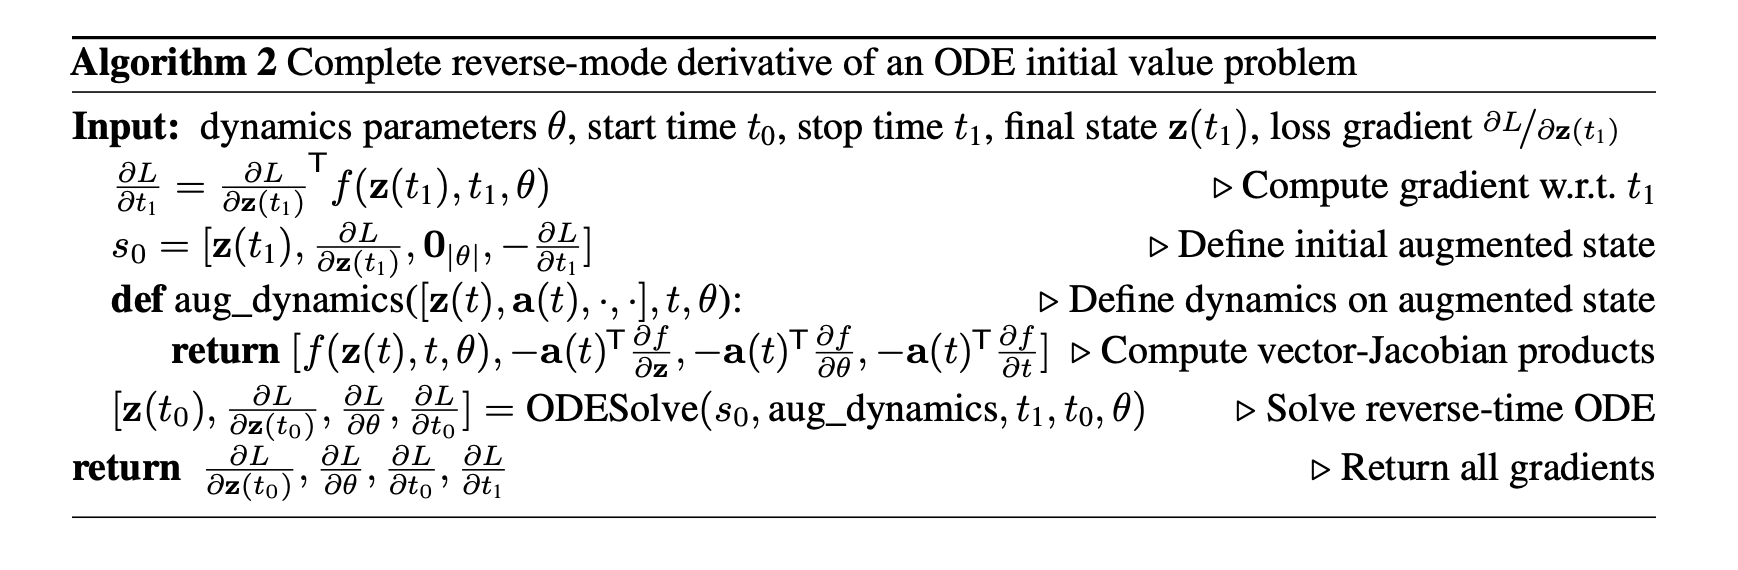

In [12]:
display(Image('figures/ode-backprop.png', width=800, height=300))

![ode-backprop](figures/ode-backprop.png)

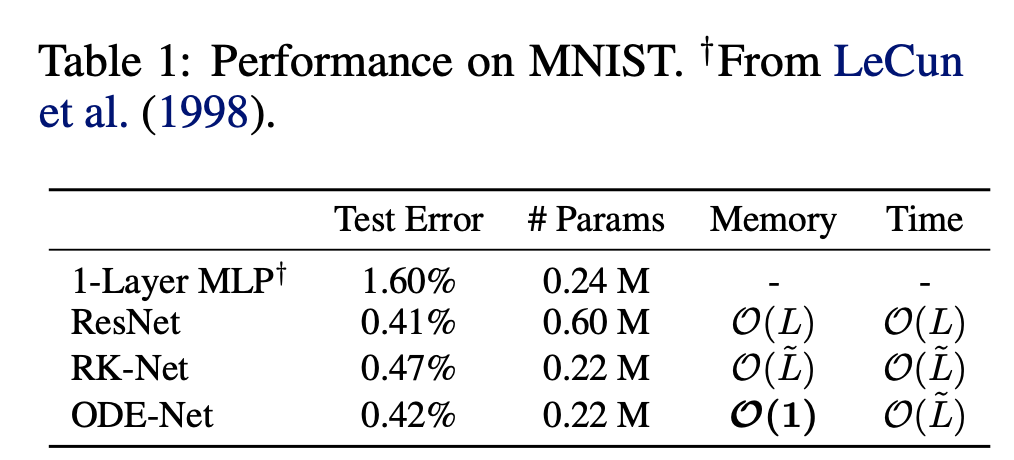

In [13]:
display(Image('figures/ode-mnist.png', width=600, height=300))

![ode-mnist](figures/ode-mnist.png)

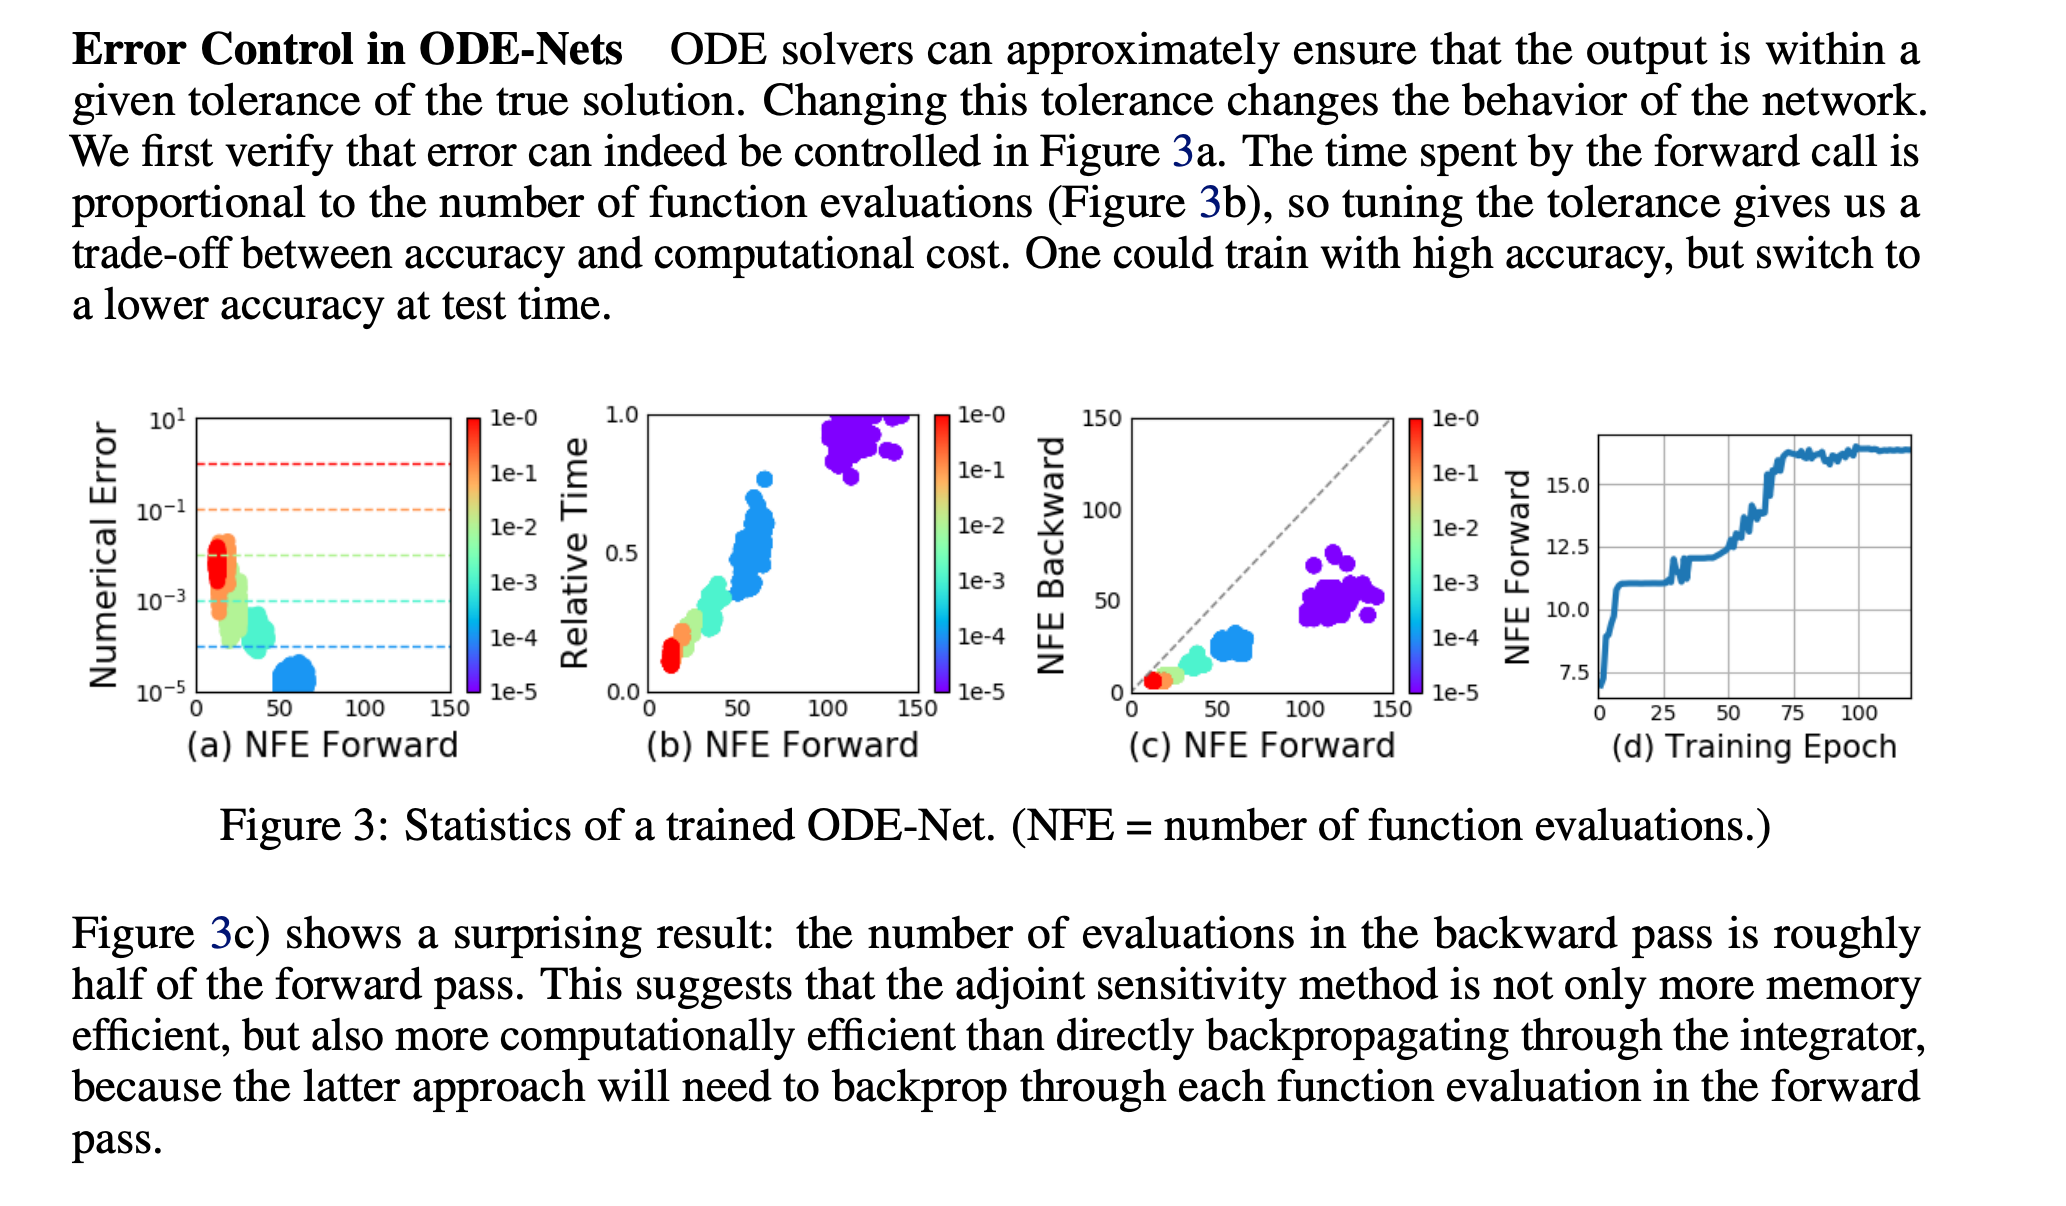

In [14]:
display(Image('figures/error-control-ode.png', width=600, height=300))

![error-control-ode](figures/error-control-ode.png)

# Thoughts on Neural ODE (NODE)

- To achieve similar capacity, NODE generally uses fewer parameters   
 - NODE dynamics model depends on time and uses the same parameters for all evaluations
 - Resnet #parameters growing roughly linearly w.r.t. #layers

- What is the __depth__ of NODE?
 - NFE: the number of dynamics function evaluation
 - Depend on initial states, error tolerance and the blackbox ODE solver
 
- Constant memory usage
 - Strictly speaking, O(1) memory w.r.t the NFE since we don’t need to cache intermediate values in the forward path; but compute as needed on the backward path from the end
 - Resnet (and DNN) usually need to cache intermediate forward computation for backward path

- NODE can replace Resnet, e.g., for classification/regression, NODE learns the feature; in the end we still need another FC layer to outputclass logits or regression value.

- Control accuracy vs. computation trade-off
 - higher NFE, more accurate; but in low-end hardware at inference time, may need to trade accuracy for computational efficiency

- Figure 3d above shows the NFE increases throughout training epochs. This suggests the model complexity increases over time, can NODE overfit over time?
 - Need some way to regularize the NFE to keep model complexity in check

## Bonus

There are functions that NODE can't represent as proved in  [Augmented NODE]((https://arxiv.org/abs/1904.01681)
 - The paper proposes to augment the original data with more dimensions, intuitively make it “linearly separable” in the new higher dim space → NODE works well



# Related Work

0. [Augmented Neural ODEs](https://arxiv.org/abs/1904.01681)
1. [FFJORD: Free-form Continuous Dynamics for Scalable Reversible Generative Models](https://arxiv.org/abs/1810.01367)
2. [Invertible Residual Networks](https://arxiv.org/pdf/1811.00995.pdf)

# Play with NODE

In [0]:
!git clone https://github.com/rtqichen/torchdiffeq.git
!pip install -e ./torchdiffeq

fatal: destination path 'torchdiffeq' already exists and is not an empty directory.
Obtaining file:///content/torchdiffeq
  Found existing installation: torchdiffeq 0.0.1
    Can't uninstall 'torchdiffeq'. No files were found to uninstall.
  Running setup.py develop for torchdiffeq


In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# May need to restart kernel to pick up odeint, odeint_adjoint
from torchdiffeq import odeint, odeint_adjoint

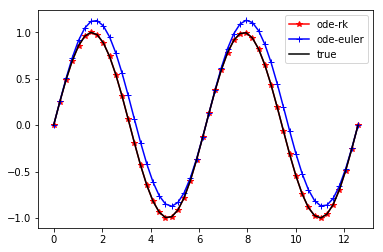

In [0]:
# Can use torch.linspace directly but use numpy for plot later without conversion
t = np.linspace(0, 4 * np.pi, num=50)
tt = torch.from_numpy(t).float()

# Initival value at t0
z0 = torch.tensor([0]).float()

fn = lambda t, z: torch.cos(t)
#print(callable(fn))

euler = odeint(fn, z0, tt, method="euler").squeeze().numpy()
#midpoint = odeint(fn, z0, tt, method="midpoint").squeeze().numpy()
# default: Runge-Kutta method
rk = odeint(fn, z0, tt).squeeze().numpy()

plt.plot(t, rk, 'r*-', label="ode-rk")
plt.plot(t, euler, 'b+-', label="ode-euler")
#plt.plot(t, midpoint,'g+-', label="ode-midpoint")
plt.plot(t, np.sin(t), 'k-', label="true")
plt.legend(loc='best')


In [0]:
help(odeint_adjoint)

Help on function odeint_adjoint in module torchdiffeq._impl.adjoint:

odeint_adjoint(func, y0, t, rtol=1e-06, atol=1e-12, method=None, options=None)



Euler NFE: 49
RK NFE: 224


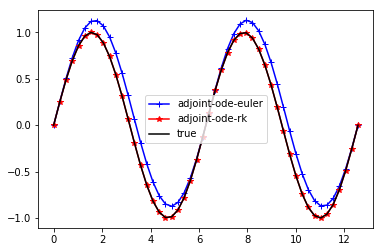

In [0]:
# Let's try ode_adjoint with O(1) memory backprop
# The gotcha is the dynamics callable needs to be a nn.Module
# See https://github.com/rtqichen/torchdiffeq documentation

class CosDynamics(nn.Module):
    def __init__(self):
        super(CosDynamics, self).__init__()
        self.nfe = 0
        
    def forward(self, t, z):
        self.nfe += 1
        return torch.cos(t)
    
dynamics = CosDynamics()
#print("dynamics is callable?", callable(dynamics))
euler_values = odeint_adjoint(dynamics, z0, tt, method="euler").squeeze().numpy()
print("Euler NFE: {}".format(dynamics.nfe))

rk_dynamics = CosDynamics()
rk_values = odeint_adjoint(rk_dynamics, z0, tt).squeeze().numpy()
print("RK NFE: {}".format(rk_dynamics.nfe))

plt.plot(t, euler_values, 'b+-', label="adjoint-ode-euler")
plt.plot(t, rk_values, 'r*-', label="adjoint-ode-rk")
plt.plot(t, np.sin(t), 'k-', label="true")
plt.legend(loc='best')
        

torch.Size([2, 1])
(50, 2)


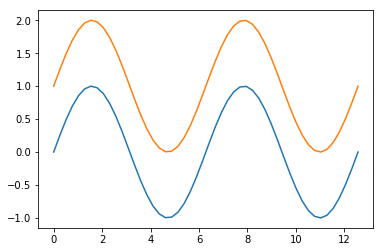

In [0]:
# We can also specify multiple (aka batched) initial values

y0 = torch.tensor([[0], [1]]).float()
print(y0.shape) # N x D

values = odeint(fn, torch.tensor([[0], [1]]).float(), tt).squeeze().numpy()

print(values.shape) # tt.shape[0] x N

plt.plot(t, values[:,0])
plt.plot(t, values[:,1])

In [0]:
# import torchvision.models as models

# resnet18 = models.resnet18()

# # print(resnet18)
# # for p in resnet18.parameters():
# #     if not p.is_contiguous():
# #         print(p)

# flat = [p.contiguous().view(-1) for p in resnet18.parameters()]
# cat_flat = torch.cat(flat)
# print(cat_flat.shape)

# def count_parameters(model):
#     """ Returns the number of trainable (aka requires_grad=True) in a nn.Module
#     """
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)

# print("Resnet18 has {} parameters".format(count_parameters(resnet18)))

In [0]:
# See also, https://pytorch.org/docs/stable/_modules/torchvision/models/resnet.html#resnet18
from torchvision.models.resnet import ResNet, BasicBlock

class MnistResNet18(ResNet):
    def __init__(self):
        super(MnistResNet18, self).__init__(BasicBlock, [2,2,2,2], num_classes=10)
        # Replace first conv layer to accept single-channel image
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
    def forward(self, x):
        return F.softmax(super(MnistResNet18, self).forward(x), dim=-1)
    


In [0]:
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect

In [0]:
mnist = MNIST(root='.', train=True, download=True)
# Normalization for MNIST in Pytorch: https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457
print("Training pixel mean: {:.4f}".format(mnist.data.float().mean() / 255.))
print("Training pixel std: {:.4f}".format(mnist.data.float().std() / 255.))


0it [00:00, ?it/s]

 99%|█████████▉| 9805824/9912422 [00:11<00:00, 2612312.03it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz



0it [00:00, ?it/s]
  0%|          | 0/28881 [00:00<?, ?it/s]


32768it [00:00, 130264.26it/s]           
0it [00:00, ?it/s]
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz



 98%|█████████▊| 1613824/1648877 [00:01<00:00, 765596.54it/s]
1654784it [00:01, 1323923.91it/s]                            
0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz



  0%|          | 0/4542 [00:00<?, ?it/s]
8192it [00:00, 49354.46it/s]            

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!
Training pixel mean: 0.1306
Training pixel std: 0.3081


In [0]:
train_bs = 64
test_bs = 64
transform = Compose([Resize((224, 224)), # resnet18 expects image size 224 x 224
                                       # ToTensor to convert image to torch.Tensor; also convert pixel values into [0, 1]
                                       ToTensor(),
                                       # Normalize with mean and std computed from training data
                                       # Same as https://pytorch.org/tutorials/intermediate/spatial_transformer_tutorial.html
                                       Normalize((0.1307,), (0.3081,))])

train_ds = MNIST(root='.', train=True, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=train_bs, shuffle=True, num_workers=4)

test_ds = MNIST(root='.', train=False, download=True, transform=transform)
test_loader = DataLoader(test_ds, batch_size=test_bs, shuffle=True, num_workers=4)

In [0]:
n_epochs = 2
lr = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

loss_fn = nn.CrossEntropyLoss()
model = MnistResNet18().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

Device: cuda


In [0]:
# Just to check if optimizer state params are on cuda
print(optimizer.param_groups[0]['params'][0].device)

cuda:0


Time: 360.8055799007416s


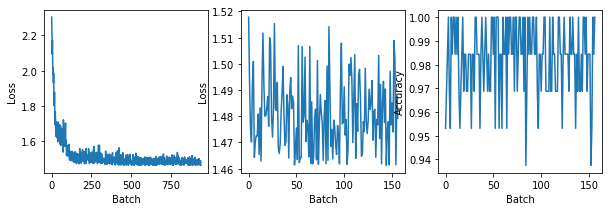

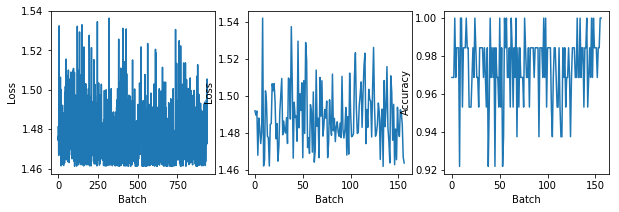

In [0]:
import time

start_ts = time.time()

for epoch in range(n_epochs):
    
    train_losses = []
    # Set train mode
    model.train()
    
    for batch in train_loader:
        bx, by = batch[0].to(device), batch[1].to(device)
        
        model.zero_grad()
        pred_logits = model(bx)
        loss = loss_fn(pred_logits, by)
        train_losses.append(loss.item())
        # backprop
        loss.backward()
        optimizer.step()
        
    # release unnecessary in GPU
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    test_losses = []
    test_acc = []
    # Eval on test data, no backprop
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            bx, by = batch[0].to(device), batch[1].to(device)
            pred_logits = model(bx)
            loss = loss_fn(pred_logits, by)
            test_losses.append(loss.item())
            
            pred_by = torch.argmax(pred_logits, 1)
            test_acc.append(accuracy_score(by.cpu(), pred_by.cpu()))
    
    fig, ax = plt.subplots(1, 3, figsize=(10,3))
    
    ax[0].plot(train_losses, label='Epoch #{}: Train loss'.format(epoch+1))
    ax[0].set_xlabel('Batch')
    ax[0].set_ylabel('Loss')
    
    ax[1].plot(test_losses, label='Epoch #{}: Test loss'.format(epoch+1))
    ax[1].set_xlabel('Batch')
    ax[1].set_ylabel('Loss')
    
    ax[2].plot(test_acc, label='Epoch #{}: Test accuracy'.format(epoch+1))
    ax[2].set_xlabel('Batch')
    ax[2].set_ylabel('Accuracy')
    
print(f"Time: {time.time() - start_ts}s")

In [0]:
# See also https://pytorch.org/tutorials/beginner/saving_loading_models.html
torch.save(model.state_dict(), 'mnist_resnet18.pth')

In [0]:
def count_parameters(model):
    """ Returns the number of trainable (aka requires_grad=True) in a nn.Module
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("MnistResnet18 has {} parameters".format(count_parameters(model)))

MnistResnet18 has 11175370 parameters
